# Joern-ey into Progol

We have [generated](./generate_minimal_ilp_dataset.ipynb) a subset of the Juliet dataset consisting of small buffer overflow examples, and have [transformed](./Joern-ey%20into%20ILP.ipynb) each piece of source code into a a set of Prolog facts. In this notebook we generate Progol scripts from this dataset, and try to get it to learn rules to determine when a buffer overflow occurs.

## Generating Progol
In this section we load in the ILP dataset and its Progol representations, manually find the "error" node in each example, then define the `make_progol_script` function which will generate a script from the given testcase id's.

In [1]:
import pandas as pd

In [2]:
import tempfile
import subprocess
import graph_visualisation

In [3]:
ilp_data = pd.read_csv("../data/ilp_dataset.csv.gz")
ilp_data = ilp_data.drop("Unnamed: 0", axis=1)
ilp_data.head()

,testcase_ID,filename,code,flaw,flaw_loc,bug,code_length
0,62804,000/062/804/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,1722
1,62821,000/062/821/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,35,False,1808
2,62852,000/062/852/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,30,False,1674
3,62853,000/062/853/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2396
4,62854,000/062/854/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2414


In [4]:
prolog = pd.read_csv("../data/ilp_prolog_data.csv.gz")
prolog = prolog.drop("Unnamed: 0", axis=1)
prolog.head()

,testcase_ID,flaw,bug,code_length,tree,source_map
0,-232086,CWE-122,True,1625,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_232086_id_1_f_l_c_, ""p..."
1,-232012,CWE-122,True,1619,% START: Generated Prolog\n% NODE PROPERTIES \...,% CODE\nsource_code(bad_232012_id_1_f_l_48_c_1...
2,-62917,CWE-121,True,1622,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62917_id_0_f_l_c_, ""p1..."
3,-62916,CWE-121,True,1649,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62916_id_0_f_l_c_, ""p1..."
4,-62915,CWE-121,True,1638,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62915_id_0_f_l_c_, ""p2..."


In [5]:
juliet = pd.read_csv("../data/buffer_overflow_data.csv.gz")
juliet.drop("Unnamed: 0", axis=1)
juliet.head()

,Unnamed: 0,Unnamed: 0.1,testcase_ID,filename,code,flaw,flaw_loc,bug
0,984,984,62516,000/062/516/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,112,False
1,985,985,62517,000/062/517/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,117,False
2,986,986,62518,000/062/518/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,117,False
3,987,987,62519,000/062/519/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,123,False
4,988,988,62520,000/062/520/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,123,False


In [6]:
prolog['source_code'] = ''
prolog['flaw_loc'] = 0
prolog['bad_code'] = ''

In [7]:
for i in range(len(prolog)):
    label = prolog.iloc[i].testcase_ID == juliet.testcase_ID
    prolog['source_code'].iloc[i] = juliet.loc[label].iloc[0].code
    prolog['flaw_loc'].iloc[i] = juliet.loc[label].iloc[0].flaw_loc
    

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
for i in range(len(prolog)):
    loc =  prolog.iloc[i].flaw_loc
    testcase_ID = prolog.iloc[i].testcase_ID
    if testcase_ID < 0:
        prolog['bad_code'].iloc[i] = prolog.iloc[i].source_code.split('\n')[loc-1].strip()[0:-1]
    else:
        prolog['bad_code'].iloc[i] = prolog.loc[prolog.testcase_ID == -testcase_ID].iloc[0].bad_code

In [9]:
prolog.head()

,testcase_ID,flaw,bug,code_length,tree,source_map,source_code,flaw_loc,bad_code
0,-232086,CWE-122,True,1625,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_232086_id_1_f_l_c_, ""p...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,31,"memmove(data, source, 10*sizeof(int))"
1,-232012,CWE-122,True,1619,% START: Generated Prolog\n% NODE PROPERTIES \...,% CODE\nsource_code(bad_232012_id_1_f_l_48_c_1...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,31,"memcpy(data, source, 10*sizeof(int))"
2,-62917,CWE-121,True,1622,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62917_id_0_f_l_c_, ""p1...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,32,"memmove(data, source, 10*sizeof(int))"
3,-62916,CWE-121,True,1649,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62916_id_0_f_l_c_, ""p1...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,34,"memmove(data, source, 10*sizeof(int))"
4,-62915,CWE-121,True,1638,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62915_id_0_f_l_c_, ""p2...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,34,"memmove(data, source, 10*sizeof(int))"


In [10]:
good_examples = prolog[prolog['bug'] == False]
bad_examples = prolog[prolog['bug'] == True]

In [11]:
good_examples.head()

,testcase_ID,flaw,bug,code_length,tree,source_map,source_code,flaw_loc,bad_code
20,62804,CWE-121,False,1722,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(good_62804_id_0_f_l_c_, ""p...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,33,data[i] = source[i]
21,62821,CWE-121,False,1808,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(good_62821_id_0_f_l_c_, ""R...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,35,data[i] = source[i]
22,62852,CWE-121,False,1674,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(good_62852_id_0_f_l_c_, ""p...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,30,"memcpy(data, source, 10*sizeof(int))"
23,62853,CWE-121,False,2396,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(good_62853_id_0_f_l_c_, ""d...",/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,33,"memcpy(data, source, 10*sizeof(int))"
24,62854,CWE-121,False,2414,% START: Generated Prolog\n% NODE PROPERTIES \...,% CODE\nsource_code(good_62854_id_0_f_memcpy_0...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,33,"memcpy(data, source, 10*sizeof(int))"


In [12]:
def extract_node_ids(tree):
    nodes = set()
    
    in_ast_section = False
    
    for line in tree.split('\n'):
        line = line.strip()
        
        if line == '% AST':
            in_ast_section = True
        
        if line == '% CFG':
            in_ast_section = False
            
        if line == '% REF':
            in_ast_section = False
        
        if in_ast_section and not line.startswith("%"):
            parent, child = line[4:-2].split(", ")
            nodes.add(parent)
            nodes.add(child)
            
    return nodes

In [13]:
# good nodes_g
nodes_g = set()

for i in range(len(good_examples)):
    good_nodes = extract_node_ids(good_examples.iloc[i].tree)
    nodes_g = set.union(nodes_g,good_nodes)

    
# bad nodes_b
nodes_b = set()

for i in range(len(bad_examples)):
    bad_nodes = extract_node_ids(bad_examples.iloc[i].tree)
    nodes_b = set.union(nodes_b,bad_nodes)

nodes = set.union(nodes_g,nodes_b)

In [14]:
node_and_tree = []
for node in nodes:
    start, end = node.split('_id')
    node_and_tree.append('(' +start+ ', ' +node+ ')')

node_and_tree[0:5]

['(bad_232086, bad_232086_id_167_f_memmove_01_c_l_25_c_4_)',
 '(bad_62867, bad_62867_id_153_f_l_c_)',
 '(good_62916, good_62916_id_133_f_memmove_17_c_l_35_c_30_)',
 '(bad_62868, bad_62868_id_19_f_l_c_)',
 '(good_62865, good_62865_id_106_f_memcpy_14_c_l_81_c_12_)']

In [15]:
def extract_tree_ids(tree):
    line = tree.split('\n')[2]
    line = line.strip()
    line = line.split('(')[1]
    tree_id = line.split('_id')[0]

    return tree_id

In [16]:
tree_ids = []
for tree in prolog.tree:
    tree_ids.append(extract_tree_ids(tree))

In [17]:
trees = [
    'tree('+ tree_label +').' for tree_label in tree_ids
]

In [22]:
bad_node = []
good_node = []

for tree in tree_ids:
    if tree[0:3] == 'bad':
        bad_node.append(tree)
    else:
        good_node.append(tree)

In [24]:
good_node

['good_62804',
 'good_62821',
 'good_62852',
 'good_62853',
 'good_62854',
 'good_62861',
 'good_62865',
 'good_62867',
 'good_62868',
 'good_62869',
 'good_62900',
 'good_62901',
 'good_62902',
 'good_62909',
 'good_62913',
 'good_62915',
 'good_62916',
 'good_62917',
 'good_232012',
 'good_232086']

In [25]:
node_tree_types = [
    'node'+ node_tree +'.' for node_tree in node_and_tree
]

tree_positive_examples = [
    'bug('+node_id+').' for node_id in bad_node
]

tree_negative_examples = [
    ':- bug('+node_id+').' for node_id in good_node
]

In [26]:
def make_progol_script_tag_whole_tree(header, testcases):
    script_template = """
{header}

%%Trees
{trees}

%% Types
{types}

%% background knowledge
{bg_knowledge}

%% learning task
%% positive examples
{positive_examples}

%% negative examples
{negative_examples}

    """
    script = script_template.format(
        header = header,
        trees =  '\n'.join(trees),
        types = '\n'.join(node_tree_types),
        bg_knowledge = '\n'.join(prolog['tree']),
        positive_examples='\n'.join(tree_positive_examples),
        negative_examples='\n'.join(tree_negative_examples),
    )
    
    # remove all lines not related to this testcase
    script = '\n'.join([
        line for line in script.split("\n")  if any(
            str(testcase) in line for testcase in testcases
        ) or not ("good_" in line or "bad_" in line)
    ])
    
    return script

In [27]:
script

NameError: name 'script' is not defined

## Experimentation
In this section we try different subsets of the dataset with different Progol settings. 

We try by setting the following header:

In [30]:
header = """
% Settings
:- set(c,30)?
:- set(i,30)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
"""

script = make_progol_script_tag_whole_tree(header, {62804, 62852, 62869, 232012, 62900})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232012).]
[Generalising <bug(bad_232012).>]
[Most specific clause is]

bug(A).

[C:19,25,5,0 bug(A).]
[1 explored search nodes]
f=19,p

This creates one rule per example, but is unable to create a general one. These rules succinctly describe the situation, and three of the examples have the same rule!

```
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), assignment(A), ast(B,C), compMemberAccess(B), ref(C,D).
```

We try the same setup, but only for those buffer overflows which happen due to a `memcpy`:

In [32]:
script = make_progol_script_tag_whole_tree(header, {
    62852,
    62853,
    62854,
    62869,
    232012,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232012).]
[Generalising <bug(bad_232012).>]
[Most specific clause is]

bug(A).

[C:19,25,5,0 bug(A).]
[1 explored search nodes]
f=19,p

It produces 5 of the exact same "most specific clauses", but is still unable to give a final output?
```
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), ast(B,D), ref(C,E), ast(D,F), sizeOf(D).
```

**Question:** Why is it unable to combine them?

Finally, try for all the examples:

In [34]:
script = make_progol_script_tag_whole_tree(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086).]
[Generalising <bug(bad_232086).>]
[Most specific clause is]

bug(A).

[C:39,50,10,0 bug(A).]
[1 explored search nodes]
f=39,

It produces two different rules (grouped below by rule not output or testcase):

```
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C, E), ast(D,F), sizeOf(D).
bug(A) :- ast(A,B), assignment(A), ast(B,C), compMemberAccess(B), ref(C,D).
```

The first rule is generated for all buffer overflows which make use of a bulk memory operation (e.g. `memcpy` and `memmove`) whilst the second rule is for the examples where an array is copied item by item. 

What do these rules mean? Let's visualise them to find out:

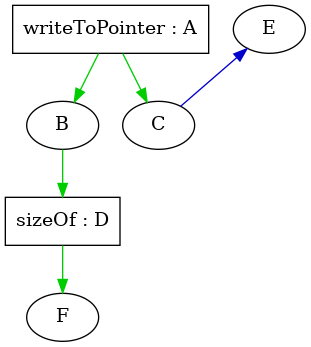

In [23]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C,E), ast(D,F), sizeOf(D)."
))

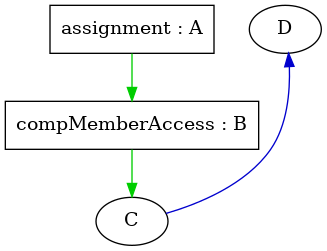

In [24]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), assignment(A), ast(B,C), compMemberAccess(B), ref(C,D)."
))

**Question:** Can ILP learn logical or's? And so could these three rules be considered in composite?

**Question:** Can we create probabilistic model from these rules?

In [35]:
script = make_progol_script_tag_whole_tree("""
% Settings
:- set(c,40)?
:- set(i,40)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,200)?
:- set(noise,0.2)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, cfg(+node,-node))?
:- modeb(*, cfg(-node,+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))? """, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,40)? - Time taken 0.00s]
[:- set(i,40)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,200)? - Time taken 0.00s]
[:- set(noise,0.200)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,cfg(+node,-node))? - Time taken 0.00s]
[:- modeb(100,cfg(-node,+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[General

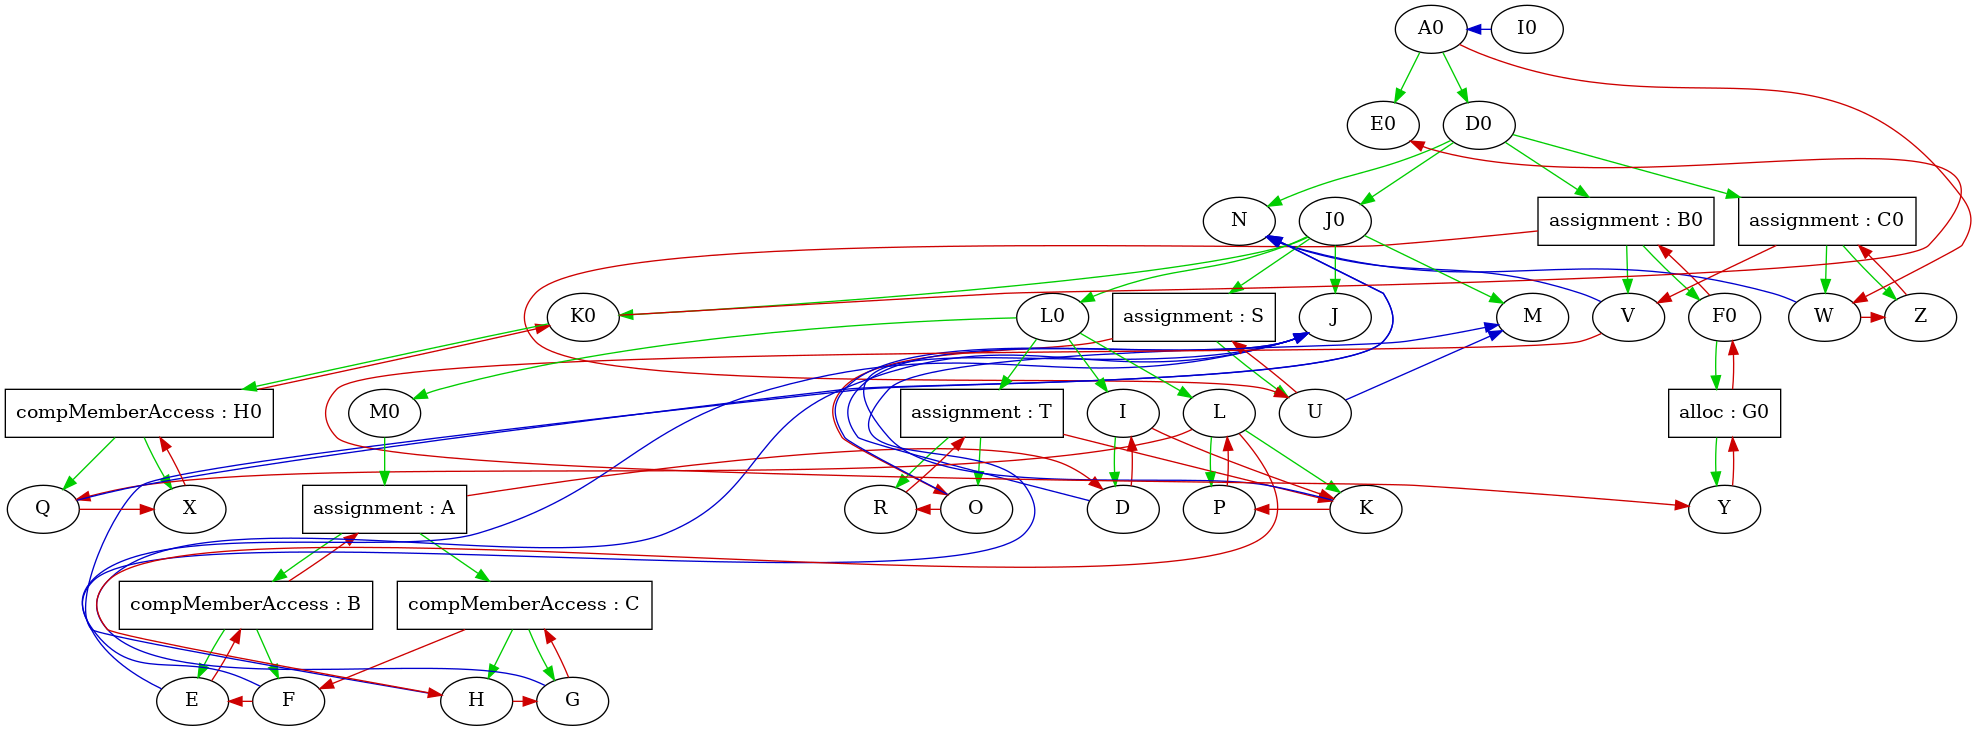

In [26]:
rule = "bug(A) :- ast(A,B), ast(A,C), cfg(A,D), cfg(B,A), assignment(A), ast(B,E), ast(B,F), ast(C,G), ast(C,H), cfg(C,F), cfg(D,I), cfg(E,B), cfg(G,C), ref(D,J), compMemberAccess(B), compMemberAccess(C), ast(I,D), cfg(F,E), cfg(H,G), cfg(I,K), cfg(L,H), ref(E,J), ref(F,M), ref(G,J), ref(H,N), ref(K,J), ref(O,J), ast(L,K), ast(L,P), cfg(K,P), cfg(L,Q), cfg(O,R), cfg(P,L), cfg(S,O), cfg(T,K), ref(Q,N), ref(U,M), ref(V,N), ref(W,N), ast(S,U), ast(T,O), ast(T,R), cfg(R,T), cfg(Q,X), cfg(U,S), cfg(V,Y), cfg(W,Z), cfg(A0,W), cfg(B0,U), cfg(C0,V), assignment(S), assignment(T), ast(A0,D0), ast(A0,E0), ast(B0,V), ast(B0,F0), ast(C0,W), ast(C0,Z), cfg(Z,C0), cfg(Y,G0), cfg(X,H0), cfg(F0,B0), ref(I0,A0), assignment(B0), assignment(C0), ast(F0,G0), ast(D0,N), ast(D0,B0), ast(D0,C0), ast(D0,J0), ast(H0,Q), ast(H0,X), ast(G0,Y), cfg(H0,K0), cfg(G0,F0), cfg(K0,E0), compMemberAccess(H0), alloc(G0), ast(J0,J), ast(J0,M), ast(J0,S), ast(J0,K0), ast(J0,L0), ast(K0,H0), ast(L0,I), ast(L0,L), ast(L0,T), ast(L0,M0), ast(M0,A)."
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(rule))

## High-level Rules

As we add more examples, Progol is able to learn more complex rules. However, the long rules can become noisy, and make it much harder to find rules which apply generally. In this section we try to add a bunch of rules which give Progol the opportunity to compress its rules into smaller, normalised forms.

### `runs_before`
First, we add the `runs_before` relation, which should compress and normalise many CFG relations. For example, if ILP had found the following two rules:

  1. `bug(A) :- writeToPointer(A), cfg(A,B), cfg(B,C), cfg(C,D), alloc(D).`
  2. `bug(A) :- writeToPointer(A), cfg(A,B), alloc(B).`
  
It may not be able to reconcile them. But, we (the humans) know that it doesn't really matter that there were three cfg edges instead of one, we only care that the allocation happened before the `writeToPointer`. 

In [36]:
header = """
% Settings
:- set(c,10)?
:- set(i,10)?
:- set(h,1000)?
:- set(cover)?
:- set(inflate,200)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?

:- modeb(10, runs_before(+node, -node))?

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,B), cfg(B,C).
"""

script = make_progol_script_tag_whole_tree(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})
with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,10)? - Time taken 0.00s]
[:- set(i,10)? - Time taken 0.00s]
[:- set(h,1000)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,200)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(10,runs_before(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086).]
[Generalising <bug(bad_232086).>]
[Most specific clause is]

bu

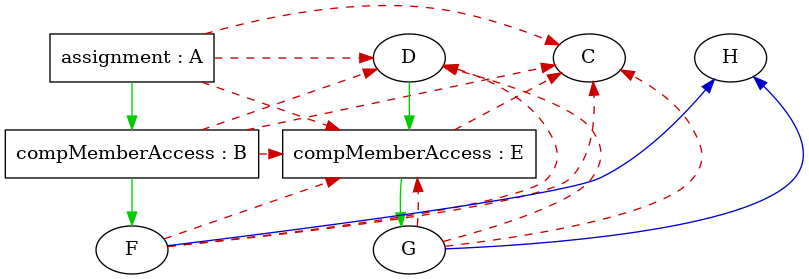

In [28]:
rule = "bug(A) :- ast(A,B), assignment(A), runs_before(A,C), runs_before(A,D), runs_before(A,E), ast(B,F), ast(D,E), ast(E,G), compMemberAccess(B), compMemberAccess(E), runs_before(B,C), runs_before(B,D), runs_before(B,E), runs_before(E,C), ref(F,H), ref(G,H), runs_before(F,C), runs_before(F,D), runs_before(F,E), runs_before(G,C), runs_before(G,D), runs_before(G,E)."
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(rule))

### `ancestor`

Next, we add an equivelant for the `ast` relation, `ancestor`:

In [37]:
header = """
% Settings
:- set(c,5)?
:- set(i,4)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, assignment(+node))?
:- modeb(*, compMemberAccess(+node))?
:- modeb(*, sizeOf(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?

:- modeb(20, runs_before(+node, -node))?

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,B), cfg(B,C).

:- modeb(20, ancestor(+node, -node))?

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,B), ast(B,C).
"""

script = make_progol_script_tag_whole_tree(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})
with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,5)? - Time taken 0.00s]
[:- set(i,4)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,assignment(+node))? - Time taken 0.00s]
[:- modeb(100,compMemberAccess(+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(20,runs_before(+node,-node))? - Time taken 0.00s]
[:- modeb(20,ancestor(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086).]
[Generalising <bug(bad_232086).>]
[Most specific clause is]

bug(A).

[C:39,50,10,0 bug(A).]
[1 explored search 

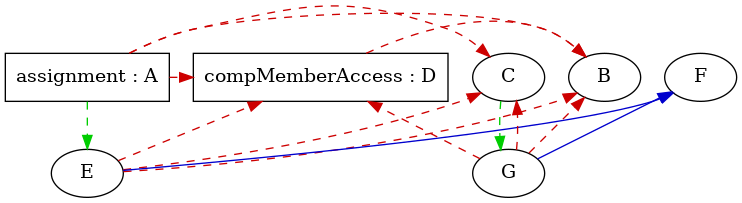

In [30]:
rule = "bug(A) :- assignment(A), runs_before(A,B), runs_before(A,C), runs_before(A,D), ancestor(A,E), ref(E,F), compMemberAccess(D), runs_before(D,B), runs_before(E,B), runs_before(E,C), runs_before(E,D), ancestor(C,G), ref(G,F), runs_before(G,B), runs_before(G,C), runs_before(G,D)."
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(rule))

Rule above shows the system has found related edges, but hasn't found the need to constrain them as much as a human would deem necessary. E.g. there has to be something about B and F that relates them to the bug more than just being references. Potential causes of this issue:

  1. We haven't given the system enough information about the C, B, F nodes for it to extract defining features of them.
  2. We haven't given it a high enough variety of inputs for the rule to need these extra distinguishing features.

It's probably a combination of the two.

### `writeToPointer`

In 

In [41]:
header = """
% Settings
:- set(c,30)?
:- set(i,30)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+tree))?

:- modeb(*, ast(+node,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?

writeToPointer(A) :- ast(A, B), assignment(A), compMemberAccess(B). 
"""

script = make_progol_script_tag_whole_tree(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,30)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+tree))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086).]
[Generalising <bug(bad_232086).>]
[Most specific clause is]

bug(A).

[C:39,50,10,0 bug(A).]
[1 explored search nodes]
f=39,p=50,n=10,h=0
[No compression]

[Generalising bug(bad_232012).]
[Generalising <bug(bad_232012).>]
[Most specific c

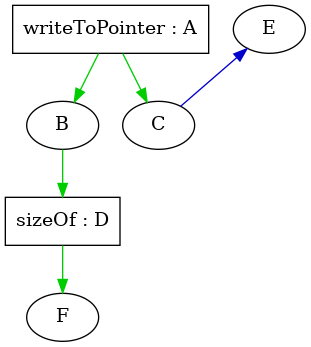

In [32]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), ast(A,C), writeToPointer(A), ast(B,D), ref(C,E), ast(D,F), sizeOf(D)."
))

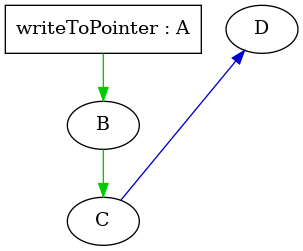

In [33]:
graph_visualisation.jupyter_display_graph(graph_visualisation.prolog_rule_to_dot(
        "bug(A) :- ast(A,B), writeToPointer(A), ast(B,C), ref(C,D)."
))

### `ancestor` and `writeToPointer`

In [55]:
header = """
% Settings
:- set(c,5)?
:- set(i,30)?
:- set(h,500)?
:- set(inflate,500)?

% Mode declarations
:- modeh(*, bug(+tree))?

:- modeb(*, node(+tree,-node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, sizeOf(+node))?
:- modeb(*, malloc(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
:- modeb(*, ancestor(+node, -node))?
:- modeb(*, ancestor(-node, +node))?
:- modeb(*, ast(+node, -node))?

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,B), ast(B,C).

writeToPointer(A) :- ast(A, B), assignment(A), compMemberAccess(B). 

"""

script = make_progol_script_tag_whole_tree(header, {
    62804,
    62852,
    62853,
    62854,
    62869,
    62900,
    62901,
    62917,
    232012,
    232086,
})

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,5)? - Time taken 0.00s]
[:- set(i,30)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[:- set(inflate,500)? - Time taken 0.00s]
[:- modeh(100,bug(+tree))? - Time taken 0.00s]
[:- modeb(100,node(+tree,-node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,malloc(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(100,ancestor(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ancestor(-node,+node))? - Time taken 0.00s]
[:- modeb(100,ast(+node,-node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086).]
[Generalising <bug(bad_232086).>]
^C


## Root Nodes

In [48]:
def find_root_node(tree, nodes):
    """
    Given a <tree_id> e.g. bad_62804 and the list of all node ids, <nodes>, return the root node of the 
    """
    tree_nodes = [node for node in nodes if tree in node]
    
    # root node of each tree seems to be the one with the largest id
    max_id = 0
    root_node = None
    
    for node in tree_nodes:
        node_id = int(node.split("_")[3])
        if node_id >= max_id:
            max_id = node_id
            root_node = node
            
    return root_node

In [49]:
root_nodes = [find_root_node(tree, nodes) for tree in tree_ids]
root_nodes[0:5]

['bad_232086_id_185_f_l_c_',
 'bad_232012_id_185_f_l_c_',
 'bad_62917_id_151_f_l_c_',
 'bad_62916_id_174_f_l_c_',
 'bad_62915_id_153_f_l_c_']

In [50]:
root_positive_examples = [
    "bug(" + node + ").\n" for node in root_nodes if 'bad' in node
]
root_negative_examples = [
    ":- bug("+ node + ").\n" for node in root_nodes if 'good' in node
]

In [52]:
def make_progol_script_tag_whole_tree_root_bug(header, testcases):
    script_template = """
{header}

%%Trees
{trees}

%% Types
{types}

%% background knowledge
{bg_knowledge}

%% learning task
%% positive examples
{positive_examples}

%% negative examples
{negative_examples}

    """
    script = script_template.format(
        header = header,
        trees =  '\n'.join(trees),
        types = '\n'.join(node_tree_types),
        bg_knowledge = '\n'.join(prolog['tree']),
        positive_examples='\n'.join(root_positive_examples),
        negative_examples='\n'.join(root_negative_examples),
    )
    
    # remove all lines not related to this testcase
    script = '\n'.join([
        line for line in script.split("\n")  if any(
            str(testcase) in line for testcase in testcases
        ) or not ("good_" in line or "bad_" in line)
    ])
    
    return script

In [54]:
header = """
% Settings
:- set(c,3)?
:- set(i,3)?
:- set(h,500)?
:- set(cover)?
:- set(inflate,1500)?

% Mode declarations
:- modeh(*, bug(+node))?

:- modeb(*, ref(+node,-node))?
:- modeb(*, ref(-node,+node))?

:- modeb(*, sizeOf(+node))?
:- modeb(*, alloc(+node))?
:- modeb(*, writeToPointer(+node))?
:- modeb(*, alloc_doesnt_check_sizeOf(+node))?
:- modeb(*, ancestor(+node, -node))?
:- modeb(*, ancestor(-node, +node))?
%:- modeb(*, runs_before(+node, -node))?

writeToPointer(A) :- ast(A, B), assignment(A), compMemberAccess(B). 

contains_sizeOf_call(A) :- ancestor(A, B), sizeof(B).
alloc_doesnt_check_sizeOf(A) :- alloc(A), not(contains_sizeOf_call(A)).

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,B), ast(B,C).

%runs_before(A,C) :- cfg(A,B), runs_before(B,C).
%runs_before(A,C) :- cfg(A,B), cfg(B,C).
"""

testcases = {
    62852, 62900, 62869, 62804, 232012, 62853, 62917, 232086, 62901, 62854, 62867, 62902, 62915, 62868, 62861, 62916, 62909, 62865, 62913, 62821
}

script = make_progol_script_tag_whole_tree_root_bug(
    header,
    testcases
)

with open("/tmp/progol_input.pl", "w") as f:
    f.write(script)

!/progol/source/progol /tmp/progol_input.pl

CProgol Version 5.0

[:- set(c,3)? - Time taken 0.00s]
[:- set(i,3)? - Time taken 0.00s]
[:- set(h,500)? - Time taken 0.00s]
[The cover flag has been turned ON]
[:- set(cover)? - Time taken 0.00s]
[:- set(inflate,1500)? - Time taken 0.00s]
[:- modeh(100,bug(+node))? - Time taken 0.00s]
[:- modeb(100,ref(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ref(-node,+node))? - Time taken 0.00s]
[:- modeb(100,sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,alloc(+node))? - Time taken 0.00s]
[:- modeb(100,writeToPointer(+node))? - Time taken 0.00s]
[:- modeb(100,alloc_doesnt_check_sizeOf(+node))? - Time taken 0.00s]
[:- modeb(100,ancestor(+node,-node))? - Time taken 0.00s]
[:- modeb(100,ancestor(-node,+node))? - Time taken 0.00s]
[Testing for contradictions]
[No contradictions found]
[Generalising bug/1]
[Generalising bug(bad_232086_id_185_f_l_c_).]
[Generalising <bug(bad_232086_id_185_f_l_c_).>]
bug(A) :- ref(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ancestor(A,F), ancestor(A,G), 

bug(A) :- ref(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), ancestor(A,I), ancestor(A,J), ancestor(A,K), ancestor(A,L), ancestor(A,M), ancestor(A,N), ancestor(A,O), ancestor(A,P), ancestor(A,Q), ancestor(A,R), ancestor(A,S), ancestor(A,T), ancestor(A,U), ancestor(A,V), ancestor(A,W), ancestor(A,X), ancestor(A,Y), ancestor(A,Z), ancestor(A,A0), ancestor(A,B0), ancestor(A,C0), ancestor(A,D0), ancestor(A,E0), ancestor(A,F0), ancestor(A,G0), ancestor(A,H0), ancestor(A,I0), ancestor(A,J0), ancestor(A,K0), ancestor(A,L0), ancestor(A,M0), ancestor(A,N0), ancestor(A,O0), ancestor(A,P0), ancestor(A,Q0), ancestor(A,R0), ancestor(A,S0), ancestor(A,T0), ancestor(A,U0), ancestor(A,V0), ancestor(A,W0), ancestor(A,X0), ancestor(A,Y0), ancestor(A,Z0), ancestor(A,A1), ancestor(A,B1), ancestor(A,C1), ancestor(A,D1), ancestor(A,E1), ancestor(A,F1), ref(G1,B), ancestor(G1,H1), ancestor(G1,I1), ancestor(G1,J1), ancestor(G1,K1), ancestor(G1,L1), ancestor(G1,

bug(A) :- ref(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), ancestor(A,I), ancestor(A,J), ancestor(A,K), ancestor(A,L), ancestor(A,M), ancestor(A,N), ancestor(A,O), ancestor(A,P), ancestor(A,Q), ancestor(A,R), ancestor(A,S), ancestor(A,T), ancestor(A,U), ancestor(A,V), ancestor(A,W), ancestor(A,X), ancestor(A,Y), ancestor(A,Z), ancestor(A,A0), ancestor(A,B0), ancestor(A,C0), ancestor(A,D0), ancestor(A,E0), ancestor(A,F0), ancestor(A,G0), ancestor(A,H0), ancestor(A,I0), ancestor(A,J0), ancestor(A,K0), ancestor(A,L0), ancestor(A,M0), ancestor(A,N0), ancestor(A,O0), ancestor(A,P0), ancestor(A,Q0), ancestor(A,R0), ancestor(A,S0), ancestor(A,T0), ancestor(A,U0), ancestor(A,V0), ancestor(A,W0), ancestor(A,X0), ancestor(A,Y0), ancestor(A,Z0), ancestor(A,A1), ancestor(A,B1), ancestor(A,C1), ancestor(A,D1), ancestor(A,E1), ancestor(A,F1), ref(G1,B), ancestor(G1,H1), ancestor(G1,I1), ancestor(G1,J1), ancestor(G1,K1), ancestor(G1,L1), ancestor(G1,

bug(A) :- ref(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), ancestor(A,I), ancestor(A,J), ancestor(A,K), ancestor(A,L), ancestor(A,M), ancestor(A,N), ancestor(A,O), ancestor(A,P), ancestor(A,Q), ancestor(A,R), ancestor(A,S), ancestor(A,T), ancestor(A,U), ancestor(A,V), ancestor(A,W), ancestor(A,X), ancestor(A,Y), ancestor(A,Z), ancestor(A,A0), ancestor(A,B0), ancestor(A,C0), ancestor(A,D0), ancestor(A,E0), ancestor(A,F0), ancestor(A,G0), ancestor(A,H0), ancestor(A,I0), ancestor(A,J0), ancestor(A,K0), ancestor(A,L0), ancestor(A,M0), ancestor(A,N0), ancestor(A,O0), ancestor(A,P0), ancestor(A,Q0), ancestor(A,R0), ancestor(A,S0), ancestor(A,T0), ancestor(A,U0), ancestor(A,V0), ancestor(A,W0), ancestor(A,X0), ancestor(A,Y0), ancestor(A,Z0), ancestor(A,A1), ancestor(A,B1), ancestor(A,C1), ancestor(A,D1), ancestor(A,E1), ancestor(A,F1), ref(G1,B), ancestor(G1,H1), ancestor(G1,I1), ancestor(G1,J1), ancestor(G1,K1), ancestor(G1,L1), ancestor(G1,

bug(A) :- ref(A,B), ancestor(A,C), ancestor(A,D), ancestor(A,E), ancestor(A,F), ancestor(A,G), ancestor(A,H), ancestor(A,I), ancestor(A,J), ancestor(A,K), ancestor(A,L), ancestor(A,M), ancestor(A,N), ancestor(A,O), ancestor(A,P), ancestor(A,Q), ancestor(A,R), ancestor(A,S), ancestor(A,T), ancestor(A,U), ancestor(A,V), ancestor(A,W), ancestor(A,X), ancestor(A,Y), ancestor(A,Z), ancestor(A,A0), ancestor(A,B0), ancestor(A,C0), ancestor(A,D0), ancestor(A,E0), ancestor(A,F0), ancestor(A,G0), ancestor(A,H0), ancestor(A,I0), ancestor(A,J0), ancestor(A,K0), ancestor(A,L0), ancestor(A,M0), ancestor(A,N0), ancestor(A,O0), ancestor(A,P0), ancestor(A,Q0), ancestor(A,R0), ancestor(A,S0), ancestor(A,T0), ancestor(A,U0), ancestor(A,V0), ancestor(A,W0), ancestor(A,X0), ancestor(A,Y0), ancestor(A,Z0), ancestor(A,A1), ancestor(A,B1), ancestor(A,C1), ancestor(A,D1), ancestor(A,E1), ancestor(A,F1), ref(G1,B), ancestor(G1,H1), ancestor(G1,I1), ancestor(G1,J1), ancestor(G1,K1), ancestor(G1,L1), ancestor(G1,